In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('../01_data/03_final/emission.csv')

In [5]:
data = data.loc[~(data['CO2_Emission'] == 0)]
#data = data.loc[~(data['Year'] > 2015)]
#data = data.loc[~(data['Year'] < 1998)]

In [6]:
data

,ORSPL,PLANT_NAME,rggi,Low_Income,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,Year,CO2_Emission,Post
8,546,Montville Station,1,0,ST,>=25,Oil,1995,1059754.000,0
16,562,Middletown,1,0,ST,>=25,Natural Gas,1995,1084978.000,0
25,568,Bridgeport Station,1,1,ST,>=25,Coal,1995,2698967.000,0
27,589,J C McNeil,1,1,ST,>=25,Biomass,1995,209528.000,0
36,593,Edge Moor,1,0,ST,>=25,Natural Gas,1995,2677884.000,0
...,...,...,...,...,...,...,...,...,...,...
96114,58005,Panda Sherman Power Station,0,0,CC,>=25,Natural Gas,2016,1131333.934,1
96168,58325,Charles D. Lamb Energy Center,0,0,GT,>=25,Natural Gas,2016,26593.466,1
96176,58420,Panda Liberty Generation Plant,0,0,CC,>=25,Natural Gas,2016,493375.010,1
96180,58427,Lansing BWL REO Town Plant,0,1,CC,>=25,Natural Gas,2016,189093.106,1


In [78]:
data_info = data.info()
missing_values = data.isnull().sum()

# Prepare data by subsetting for relevant years (before 2005 and after 2008)
data_pre_2005 = data[data['Year'] < 2005]
data_post_2008 = data[data['Year'] > 2008]

# Display data info, missing values, and the number of rows for the subsetted data
data_info, missing_values, data_pre_2005.shape[0], data_post_2008.shape[0]

<class 'pandas.core.frame.DataFrame'>
Index: 21591 entries, 8 to 96187
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ORSPL         21591 non-null  int64  
 1   PLANT_NAME    21591 non-null  object 
 2   rggi          21591 non-null  int64  
 3   Low_Income    21591 non-null  int64  
 4   PRIME_MOVER   21591 non-null  object 
 5   UNIT_SIZE     21591 non-null  object 
 6   FUEL_TYPE     21591 non-null  object 
 7   Year          21591 non-null  int64  
 8   CO2_Emission  21591 non-null  float64
 9   Post          21591 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 2.3+ MB


(None,
 ORSPL           0
 PLANT_NAME      0
 rggi            0
 Low_Income      0
 PRIME_MOVER     0
 UNIT_SIZE       0
 FUEL_TYPE       0
 Year            0
 CO2_Emission    0
 Post            0
 dtype: int64,
 7270,
 10196)

In [79]:
# Group by 'rggi' and 'Year', and calculate mean CO2 emissions for each group
pre_grouped = data_pre_2005.groupby(['rggi']).CO2_Emission.mean()
post_grouped = data_post_2008.groupby(['rggi']).CO2_Emission.mean()

# Calculate the changes in CO2 emissions for treated and control groups
change_control = post_grouped[0] - pre_grouped[0]
change_treated = post_grouped[1] - pre_grouped[1]

# Calculate the Difference-in-Differences estimator
did_estimator = change_treated - change_control

(pre_grouped, post_grouped, change_control, change_treated, did_estimator)

(rggi
 0    2.855612e+06
 1    1.132359e+06
 Name: CO2_Emission, dtype: float64,
 rggi
 0    1.789691e+06
 1    3.292090e+05
 Name: CO2_Emission, dtype: float64,
 -1065920.6101728247,
 -803150.4939988044,
 262770.11617402034)

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare a dataset for regression by concatenating pre and post datasets and creating an interaction term
#data_did = pd.concat([data_pre_2005, data_post_2008])
data_did = data
data_did['post'] = (data_did['Year'] > 2008).astype(int)
data_did['treatment'] = data_did['rggi']
data_did['treatment_post'] = data_did['post'] * data_did['treatment']

# Define and fit the regression model
model = ols('CO2_Emission ~ treatment + post + treatment_post', data=data_did).fit()

# Extract p-value for the interaction term (DiD estimator)
p_value = model.pvalues['treatment_post']

# Create a pivot table for plotting average emissions by year and treatment status
pivot_table = data_did.pivot_table(values='CO2_Emission', index='Year', columns='rggi', aggfunc='mean')

p_value, pivot_table

(0.16170140525859375,
 rggi             0             1
 Year                            
 1995  3.632055e+06  1.803812e+06
 1996  3.389726e+06  1.468560e+06
 1997  3.372650e+06  1.619039e+06
 1998  3.430487e+06  1.767125e+06
 1999  3.231342e+06  1.669280e+06
 2000  3.003731e+06  1.202356e+06
 2001  2.659388e+06  9.604151e+05
 2002  2.359605e+06  8.085067e+05
 2003  2.279141e+06  7.699531e+05
 2004  2.247731e+06  7.576860e+05
 2005  2.215818e+06  7.939986e+05
 2006  2.143369e+06  6.899394e+05
 2007  2.171168e+06  7.188598e+05
 2008  2.104265e+06  7.660330e+05
 2009  1.928049e+06  3.643034e+05
 2010  1.983262e+06  4.096006e+05
 2011  1.909589e+06  3.334562e+05
 2012  1.810487e+06  3.217426e+05
 2013  1.836396e+06  3.215415e+05
 2014  1.840507e+06  3.188537e+05
 2015  1.716114e+06  3.011162e+05
 2016  1.278308e+06  2.549154e+05)

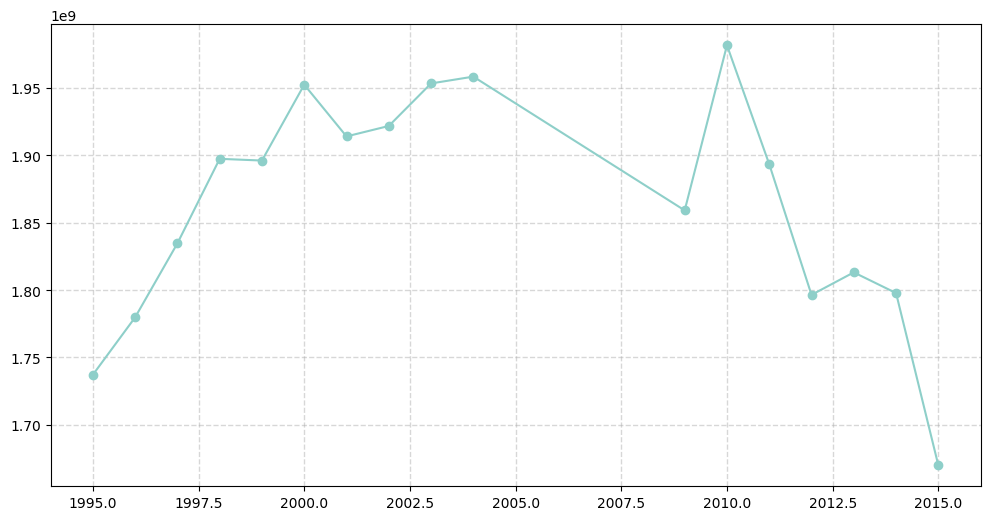

In [90]:
fig, ax = plt.subplots(figsize=(12, 6))
pivot_table2 = data_did.pivot_table(values='CO2_Emission', index='Year', columns='rggi', aggfunc='sum')
ax.plot(pivot_table2.sum(axis=1)[pivot_table.index < 2016],color=colors[0], marker='o')
ax.grid(ls='--', alpha=0.5, linewidth=1)

<Figure size 1200x600 with 0 Axes>

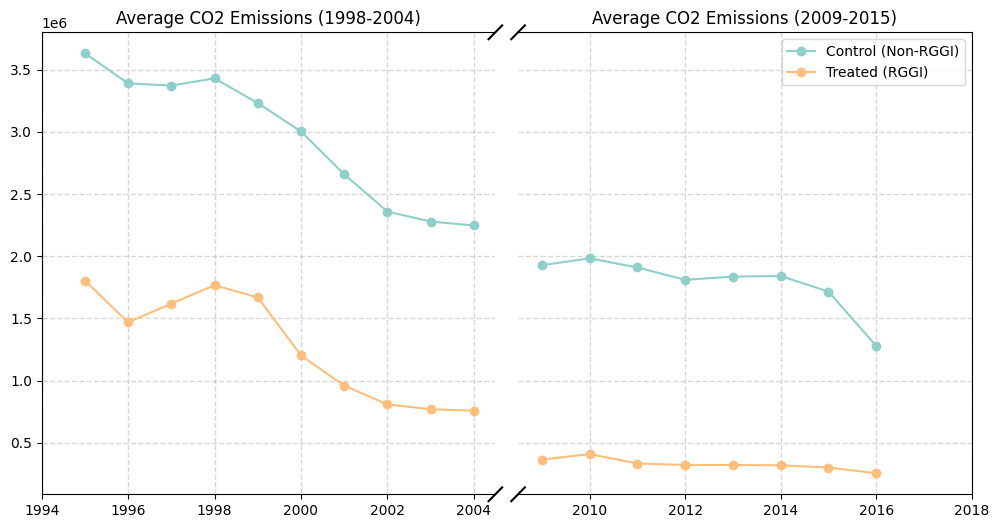

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Define two subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.05)  # Adjust space between the plots
colors = ['#8ECFC9','#FFBE7A']
# Plotting with standard axis for pre-2005 and post-2008
ax1.plot(pivot_table.index[pivot_table.index < 2005], pivot_table[0][pivot_table.index < 2005],color=colors[0],label='Control (Non-RGGI)', marker='o')
ax1.plot(pivot_table.index[pivot_table.index < 2005], pivot_table[1][pivot_table.index < 2005],color=colors[1], label='Treated (RGGI)', marker='o')
ax2.plot(pivot_table.index[pivot_table.index > 2008], pivot_table[0][pivot_table.index > 2008],color=colors[0], marker='o', label='Control (Non-RGGI)')
ax2.plot(pivot_table.index[pivot_table.index > 2008], pivot_table[1][pivot_table.index > 2008],color=colors[1], marker='o', label='Treated (RGGI)')

# Set the limits for the x-axis to create a broken axis effect
ax1.set_xlim(1994, 2004.5)  # data up to 2005
ax2.set_xlim(2008.5, 2018)  # data from 2008 onwards

# Hide the spines between ax1 and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)

# Hide the y-ticks on the second subplot
ax2.tick_params(axis='y', which='both', length=0)

# Add grid lines
ax1.grid(ls='--', alpha=0.5, linewidth=1)
ax2.grid(ls='--', alpha=0.5, linewidth=1)

# Create the 'break' marks on the axes
d = .015  # length of diagonal lines at breaks
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Add legends and set titles
ax2.legend(loc='upper right')
ax1.set_title('Average CO2 Emissions (1998-2004)')
ax2.set_title('Average CO2 Emissions (2009-2015)')

plt.show()

In [125]:
pivot_table[1][pivot_table.index == 2015]

Year
2015    1.065951e+08
Name: 1, dtype: float64

In [128]:
pivot_table[1][pivot_table.index == 2009]

Year
2009    1.355209e+08
Name: 1, dtype: float64

In [129]:
(1.065951e+08 - 1.355209e+08)/ 1.355209e+08

-0.2134416167543161

In [124]:
(pivot_table[1][pivot_table.index == 2015] - pivot_table[1][pivot_table.index == 2008]) / pivot_table[1][pivot_table.index == 2008]

Year
2008   NaN
2015   NaN
Name: 1, dtype: float64

In [106]:

# Filter the data for relevant years (before 2005 and after 2008) and exclude zero emissions
pre_2005_filtered = data[(data['Year'] < 2005) & (data['CO2_Emission'] > 0)]
post_2008_filtered = data[(data['Year'] > 2008) & (data['CO2_Emission'] > 0)]

# Group by 'rggi' and 'Year', and calculate mean CO2 emissions for each group
pre_grouped_filtered = pre_2005_filtered.groupby(['rggi']).CO2_Emission.mean()
post_grouped_filtered = post_2008_filtered.groupby(['rggi']).CO2_Emission.mean()

# Calculate the changes in CO2 emissions for treated and control groups
change_control_filtered = post_grouped_filtered[0] - pre_grouped_filtered[0]
change_treated_filtered = post_grouped_filtered[1] - pre_grouped_filtered[1]

# Calculate the Difference-in-Differences estimator
did_estimator_filtered = change_treated_filtered - change_control_filtered

# Creating a table to display the data
results_table = pd.DataFrame({
    "1998-2004 Total Emissions": pre_grouped_filtered,
    "2009-2015 Total Emissions": post_grouped_filtered,
    "Change": [change_control_filtered, change_treated_filtered]})

results_table['Change%'] = - results_table['Change'] / results_table['1998-2004 Total Emissions'] * 100
results_table['DiD Estimator'] = ['--', did_estimator_filtered]
results_table

results_table

,1998-2004 Total Emissions,2009-2015 Total Emissions,Change,Change%,DiD Estimator
rggi,,,,,
0,2.855612e+06,1.789691e+06,-1.065921e+06,37.327226,--
1,1.132359e+06,3.292090e+05,-8.031505e+05,70.927168,262770.116174


In [105]:
data2 = data.loc[~(data['Year'] > 2011)].copy()
data2 = data2.loc[~(data['Year'] < 2002)]

pre_2005_filtered = data2[(data2['Year'] < 2005) & (data2['CO2_Emission'] > 0)]
post_2008_filtered = data2[(data2['Year'] > 2008) & (data2['CO2_Emission'] > 0)]

# Group by 'rggi' and 'Year', and calculate mean CO2 emissions for each group
pre_grouped_filtered = pre_2005_filtered.groupby(['rggi']).CO2_Emission.mean()
post_grouped_filtered = post_2008_filtered.groupby(['rggi']).CO2_Emission.mean()

# Calculate the changes in CO2 emissions for treated and control groups
change_control_filtered = post_grouped_filtered[0] - pre_grouped_filtered[0]
change_treated_filtered = post_grouped_filtered[1] - pre_grouped_filtered[1]

# Calculate the Difference-in-Differences estimator
did_estimator_filtered = change_treated_filtered - change_control_filtered

# Creating a table to display the data
results_table = pd.DataFrame({
    "2002-2004 Total Emissions": pre_grouped_filtered,
    "2009-2011 Total Emissions": post_grouped_filtered,
    "Change": [change_control_filtered, change_treated_filtered]})

results_table['Change%'] =  results_table['Change'] / results_table['2002-2004 Total Emissions'] * 100
results_table['DiD Estimator'] = ['--', did_estimator_filtered]
results_table

,2002-2004 Total Emissions,2009-2011 Total Emissions,Change,Change%,DiD Estimator
rggi,,,,,
0,2.294150e+06,1.940403e+06,-353747.454527,-15.419541,--
1,7.779527e+05,3.687194e+05,-409233.372813,-52.603886,-55485.918287


In [94]:
import statsmodels.api as sm
# Prepare the data for regression analysis with interaction term
data['post_treatment'] = data['Post'] * data['rggi']

# Defining the model: CO2_Emission ~ treatment + post + post_treatment
X_filtered = data[['rggi', 'Post', 'post_treatment']]
X_filtered = sm.add_constant(X_filtered)
y_filtered = data['CO2_Emission']

# Fit the model
model_filtered = sm.OLS(y_filtered, X_filtered).fit()

# Getting the summary of the model
model_filtered_summary = model_filtered.summary()
model_filtered_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CO2_Emission   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     403.6
Date:                Wed, 01 May 2024   Prob (F-statistic):          3.95e-255
Time:                        17:45:03   Log-Likelihood:            -3.5492e+05
No. Observations:               21591   AIC:                         7.099e+05
Df Residuals:                   21587   BIC:                         7.099e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.605e+06    3.4e+04     76.625      0.000    2.54e+06    2.67e+06
rggi           -1.619e+06   8.61e+04    -18.800      0.000   -1.79e+06   -1.45e+06
Post            -8.15e+05   5.17e+04    -15.757      0.000   -9.16e+05   -7.14e+05
post_treatment  1.583e+05   1.13e+05      1.399      0.162   -6.34e+04     3.8e+05
==============================================================================
Omnibus:                    12470.407   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100637.548
Skew:                           2.747   Prob(JB):                         0.00
Kurtosis:                      12.037   Cond. No.                         7.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
import statsmodels.api as sm
# Prepare the data for regression analysis with interaction term
data2['post_treatment'] = data2['Post'] * data2['rggi']

# Defining the model: CO2_Emission ~ treatment + post + post_treatment
X_filtered = data2[['rggi', 'Post', 'post_treatment']]
X_filtered = sm.add_constant(X_filtered)
y_filtered = data2['CO2_Emission']

# Fit the model
model_filtered = sm.OLS(y_filtered, X_filtered).fit()

# Getting the summary of the model
model_filtered_summary = model_filtered.summary()
model_filtered_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CO2_Emission   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     138.3
Date:                Wed, 01 May 2024   Prob (F-statistic):           5.75e-88
Time:                        17:45:12   Log-Likelihood:            -1.7875e+05
No. Observations:               10872   AIC:                         3.575e+05
Df Residuals:                   10868   BIC:                         3.575e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.213e+06   4.38e+04     50.557      0.000    2.13e+06     2.3e+06
rggi           -1.456e+06   1.07e+05    -13.578      0.000   -1.67e+06   -1.25e+06
Post           -2.729e+05   7.74e+04     -3.524      0.000   -4.25e+05   -1.21e+05
post_treatment -1.153e+05    1.6e+05     -0.723      0.470   -4.28e+05    1.97e+05
==============================================================================
Omnibus:                     6614.658   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58873.967
Skew:                           2.893   Prob(JB):                         0.00
Kurtosis:                      12.823   Cond. No.                         6.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

----

In [7]:
import numpy as np

In [11]:
data

,ORSPL,PLANT_NAME,rggi,Low_Income,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,Year,CO2_Emission,Post
8,546,Montville Station,1,0,ST,>=25,Oil,1995,1059754.000,0
16,562,Middletown,1,0,ST,>=25,Natural Gas,1995,1084978.000,0
25,568,Bridgeport Station,1,1,ST,>=25,Coal,1995,2698967.000,0
27,589,J C McNeil,1,1,ST,>=25,Biomass,1995,209528.000,0
36,593,Edge Moor,1,0,ST,>=25,Natural Gas,1995,2677884.000,0
...,...,...,...,...,...,...,...,...,...,...
96114,58005,Panda Sherman Power Station,0,0,CC,>=25,Natural Gas,2016,1131333.934,1
96168,58325,Charles D. Lamb Energy Center,0,0,GT,>=25,Natural Gas,2016,26593.466,1
96176,58420,Panda Liberty Generation Plant,0,0,CC,>=25,Natural Gas,2016,493375.010,1
96180,58427,Lansing BWL REO Town Plant,0,1,CC,>=25,Natural Gas,2016,189093.106,1


In [ ]:
pivot_table2 = data.pivot_table(values='CO2_Emission', index='Year', columns='rggi', aggfunc='sum')

In [2]:
new = pd.read_csv('../01_data/03_final/new.csv')

In [131]:
new

,ORSPL,PLANT_NAME,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,rggi,Low_Income,FIRST_YEAR_OF_OPERATION,MAJ_FUEL_1995,MAJ_FUEL_1996,...,MAJ_FUEL_2007,MAJ_FUEL_2008,MAJ_FUEL_2009,MAJ_FUEL_2010,MAJ_FUEL_2011,MAJ_FUEL_2012,MAJ_FUEL_2013,MAJ_FUEL_2014,MAJ_FUEL_2015,MAJ_FUEL_2016
0,3,Barry,CC,>=25,Natural Gas,0,0,1954.0,NaN,NaN,...,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas
1,3,Barry,ST,>=25,Coal,0,0,1954.0,Coal,Coal,...,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal
2,7,Gadsden,ST,>=25,Natural Gas,0,1,1949.0,Coal,Coal,...,Coal,Coal,Coal,Coal,Coal,Natural Gas,Natural Gas,Coal,Natural Gas,NaN
3,8,Gorgas,ST,>=25,Coal,0,1,1951.0,Coal,Coal,...,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal
4,9,Copper,GT,>=25,Natural Gas,0,1,1980.0,Natural Gas,Natural Gas,...,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,60249,Silicon Valley Clean Water,IC,<25,Natural Gas,0,0,2015.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natural Gas,NaN
4310,60250,Swampy Acres,IC,<25,-,0,0,2002.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4311,60263,Durham AWTF,IC,<25,-,0,0,2015.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4312,60276,West Groton CHP,GT,<25,Natural Gas,1,0,2015.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natural Gas,NaN


In [136]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming 'data' is your DataFrame loaded with the appropriate data
data_after_2008 = new[new['FIRST_YEAR_OF_OPERATION'] >= 2008]
inside_rggis = data_after_2008[data_after_2008['rggi'] == 1].groupby('FIRST_YEAR_OF_OPERATION').size()
outside_rggis = data_after_2008[data_after_2008['rggi'] == 0].groupby('FIRST_YEAR_OF_OPERATION').size()

# Mann-Whitney U Test
u_stat, p_val = mannwhitneyu(inside_rggis, outside_rggis, alternative='two-sided')
print(f"U Statistic: {u_stat}, P-value: {p_val}")

U Statistic: 1.5, P-value: 0.001054122909850276


In [137]:
new

,ORSPL,PLANT_NAME,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,rggi,Low_Income,FIRST_YEAR_OF_OPERATION,MAJ_FUEL_1995,MAJ_FUEL_1996,...,MAJ_FUEL_2007,MAJ_FUEL_2008,MAJ_FUEL_2009,MAJ_FUEL_2010,MAJ_FUEL_2011,MAJ_FUEL_2012,MAJ_FUEL_2013,MAJ_FUEL_2014,MAJ_FUEL_2015,MAJ_FUEL_2016
0,3,Barry,CC,>=25,Natural Gas,0,0,1954.0,NaN,NaN,...,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas
1,3,Barry,ST,>=25,Coal,0,0,1954.0,Coal,Coal,...,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal
2,7,Gadsden,ST,>=25,Natural Gas,0,1,1949.0,Coal,Coal,...,Coal,Coal,Coal,Coal,Coal,Natural Gas,Natural Gas,Coal,Natural Gas,NaN
3,8,Gorgas,ST,>=25,Coal,0,1,1951.0,Coal,Coal,...,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal,Coal
4,9,Copper,GT,>=25,Natural Gas,0,1,1980.0,Natural Gas,Natural Gas,...,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,Natural Gas,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,60249,Silicon Valley Clean Water,IC,<25,Natural Gas,0,0,2015.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natural Gas,NaN
4310,60250,Swampy Acres,IC,<25,-,0,0,2002.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4311,60263,Durham AWTF,IC,<25,-,0,0,2015.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4312,60276,West Groton CHP,GT,<25,Natural Gas,1,0,2015.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natural Gas,NaN


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Group and summarize the data
grouped_data = new.groupby(['FIRST_YEAR_OF_OPERATION', 'rggi', 'Low_Income','PLANT_NAME']).size().reset_index(name='Count')

# Pivot the data to get years on the index and fuel types as columns, filling missing values with 0
pivot_data = grouped_data.pivot_table(index=['FIRST_YEAR_OF_OPERATION','rggi', 'Low_Income'], 
                                      columns='PLANT_NAME', 
                                      values='Count', 
                                      aggfunc='sum', 
                                      fill_value=0)

# Normalize the data by row to convert counts to percentages
pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0)

# Explicitly setting years 2005 to 2008 values to zero
for year in [2005, 2008]:
    if year in pivot_data.index.get_level_values('FIRST_YEAR_OF_OPERATION'):
        pivot_data.loc[(year, slice(None), slice(None)), :] = 0

#set up
colors = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2']
all_years = np.arange(new['FIRST_YEAR_OF_OPERATION'].min(), new['FIRST_YEAR_OF_OPERATION'].max() + 1)
# Plotting

fig, axes = plt.subplots(2, 2, figsize=(18, 15), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

plot_titles = {
    (1, 1): 'RGGI, Low Income',
    (1, 0): 'RGGI, Non-Low Income',
    (0, 1): 'Non-RGGI, Low Income',
    (0, 0): 'Non-RGGI, Non-Low Income'
}
# Generate plots for each combination of RGGI and Low Income status
for i, ((rggi, low_income), ax) in enumerate(zip(plot_titles.keys(), axes)):
    # Select the appropriate subset of data
    subset = pivot_data.xs((rggi, low_income), level=('rggi', 'Low_Income'))
    
    # Plot as a stacked bar chart using the specified colors
    subset.plot(kind='bar', ax=ax, legend=0, color=colors, width=0.9)
    ax.set_title(plot_titles[(rggi, low_income)])
    ax.set_ylabel('Percentage')
    ax.set_xlabel('FIRST_YEAR_OF_OPERATION')

# Adjust legend to be horizontal and at the bottom
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))
plt.tight_layout()
plt.show()

KeyboardInterrupt: 